In [ ]:
!pip install -r requirements.txt

In [40]:
import time
import astropy.wcs as pywcs
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
myfontsize=22
plt.rcParams.update({'font.size': myfontsize})
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,ScalarFormatter, NullFormatter,MaxNLocator, NullLocator,LogLocator
from grizli.utils import get_line_wavelengths 
from grizli import utils
plt.rcParams["text.usetex"] = False



root='outthere-hudfn'
object_id = 4375
catalog_ver='v0.1'
#Taking color scheme from Grizli
grism_colors={'F115W': (0.0, 0.6196078431372549, 0.45098039215686275),
              'F150W': (0.8352941176470589, 0.3686274509803922, 0.0),
              'F200W': (0.8, 0.4745098039215686, 0.6549019607843137)}

def make_random_cmap(ncolors=256, seed=None):
    """
    Make a matplotlib colormap consisting of (random) muted colors.

    A random colormap is very useful for plotting segmentation images.

    Parameters
    ----------
    ncolors : int, optional
        The number of colors in the colormap.  The default is 256.

    seed : int, optional
        A seed to initialize the `numpy.random.BitGenerator`. If `None`,
        then fresh, unpredictable entropy will be pulled from the OS.
        Separate function calls with the same ``seed`` will generate the
        same colormap.

    Returns
    -------
    cmap : `matplotlib.colors.ListedColormap`
        The matplotlib colormap with random colors in RGBA format.
    """
    from matplotlib import colors

    rng = np.random.default_rng(seed)
    hue = rng.uniform(low=0.0, high=1.0, size=ncolors)
    sat = rng.uniform(low=0.2, high=0.7, size=ncolors)
    val = rng.uniform(low=0.5, high=1.0, size=ncolors)
    hsv = np.dstack((hue, sat, val))
    rgb = np.squeeze(colors.hsv_to_rgb(hsv))

    return colors.ListedColormap(colors.to_rgba_array(rgb))

def get_cmap(segmap, background_color='#000000ff', seed=None):
        
        """
        Define a matplotlib colormap consisting of (random) muted
        colors.

        This is useful for plotting the segmentation array.

        Parameters
        ----------
        

        background_color : Matplotlib color, optional
            The color of the first color in the colormap.
            The color may be specified using any of
            the `Matplotlib color formats
            <https://matplotlib.org/stable/tutorials/colors/colors.html>`_.
            This color will be used as the background color (label = 0)
            when plotting the segmentation image. The default color is
            black with alpha=1.0 ('#000000ff').

        seed : int, optional
            A seed to initialize the `numpy.random.BitGenerator`. If
            `None`, then fresh, unpredictable entropy will be pulled
            from the OS. Separate function calls with the same ``seed``
            will generate the same colormap.

        Returns
        -------
        cmap : `matplotlib.colors.ListedColormap`
            The matplotlib colormap with colors in RGBA format.
        """
        
        
        from matplotlib import colors
       
        #ncolors : int
        #    The number of the colors in the colormap.
        ncolors=np.max(segmap)+1 #len(np.unique(segmap))+1
        cmap = make_random_cmap(ncolors, seed=seed)

        #if background_color is not None:
        cmap.colors[0] = colors.to_rgba(background_color)
        #print(cmap.colors)
        return cmap
    
    
"""
Function for reading emission/absorption lines, their line fluxes (line flux errors), and equivalent widths
given the threshold in signal-to-noise ratio.
"""
def get_lines(full=None,min_snr=5):
    """
    full: output fits file name from grizli (*full.fits)
    min_snr: minimum signal-to-noise ratio of emission lines to be read from file
    """

       
    
    matching_keys = [key for key in full['COVAR'].header if key.startswith('FLUX_')]
    nlines = len(matching_keys)# full['PRIMARY'].header['NUMLINES']
    line_wave_obs_dict={}
    lines_snr_dict={}
    lines_flux_dict={}
    lines_fluxerr_dict={}
    EW16_dict={}
    EW50_dict={}
    EW84_dict={}
    EW_snr_dict={}
    lines_name=[]
    #lin
    _line_wavelengths, _line_ratios = get_line_wavelengths()
    for i in range(nlines):
        lineflux=full['COVAR'].header['FLUX_%s' % str(i).zfill(3)]
        lineflux_err=full['COVAR'].header['ERR_%s' % str(i).zfill(3)]
        comments=(full['COVAR'].header.comments['FLUX_%s'  % str(i).zfill(3) ]).split()
        if lineflux_err>0:
            _snr_line=lineflux/lineflux_err
        if lineflux_err==0:
            _snr_line=-99
    
        ew16=full['COVAR'].header['EW16_%s' % str(i).zfill(3)]
        ew50=full['COVAR'].header['EW50_%s' % str(i).zfill(3)]
        ew84=full['COVAR'].header['EW84_%s' % str(i).zfill(3)]
        if (_snr_line>min_snr) & (ew50>0):
            line_wave_obs_dict['%s' % comments[0]]=_line_wavelengths['%s' % comments[0]][0]*(1+full['ZFIT_STACK'].header['Z_MAP'])
            lines_snr_dict['%s' % comments[0]]=lineflux/lineflux_err
            lines_flux_dict['%s' % comments[0]]=lineflux
            lines_fluxerr_dict['%s' % comments[0]]=lineflux_err
            # compute 16th, 50th, and 84th percentiles of the distribution of equivalent width  
            EW16_dict['%s' % comments[0]]=full['COVAR'].header['EW16_%s' % str(i).zfill(3)]
            EW50_dict['%s' % comments[0]]=full['COVAR'].header['EW50_%s' % str(i).zfill(3)]
            EW84_dict['%s' % comments[0]]=full['COVAR'].header['EW84_%s' % str(i).zfill(3)]
            EW_snr_dict['%s' % comments[0]]=ew50/((ew84-ew16)/2)
            lines_name.append(comments[0])
    
    lines_prop_dicts={'name':lines_name,
                      'wavelength_obs':line_wave_obs_dict,
                      'flux':lines_flux_dict,
                      'flux_err':lines_fluxerr_dict,
                      'snr_line':lines_snr_dict,
                      'snr_ew':EW_snr_dict,
                      'ew_16':EW16_dict,
                      'ew_50':EW50_dict,
                      'ew_84':EW84_dict}
    return lines_prop_dicts
def show_drizzled_lines(line_hdu, full_line_list=['OII', 'Hb', 'OIII', 'Ha+NII', 'Ha', 'SII', 'SIII'], 
                        size_arcsec=2, cmap='plasma_r',scale=1., dscale=1, 
                        direct_filter=['F140W', 'F160W', 'F125W', 'F105W', 'F110W', 'F098M']):
    
    """Make a figure with the drizzled line maps
    
    Parameters
    ----------
    line_hdu : `~astropy.io.fits.HDUList`
        Result from `~grizli.multifit.MultiBeam.drizzle_fit_lines`
    
    full_line_list : list
        Line species too always show
    
    size_arcsec : float
        Thumbnail size in arcsec
    
    cmap : str
        colormap string
    
    scale : float
        Scale factor for line panels
    
    dscale : float
        Scale factor for direct image panel
        
    direct_filter : list
        Filter preference to show in the direct image panel.  Step through
        and stop if the indicated filter is available.
    
    Returns
    -------
    fig : `~matplotlib.figure.Figure`
        Figure object
        
    """
    
    show_lines = []
    print('full_line_list',full_line_list)
    for line in full_line_list:
        if line in line_hdu[0].header['HASLINES'].split():
            show_lines.append(line)

    if full_line_list == 'all':
        show_lines = line_hdu[0].header['HASLINES'].split()

    #print(line_hdu[0].header['HASLINES'], show_lines)

    # Dimensions
    line_wcs = pywcs.WCS(line_hdu['DSCI'].header)
    pix_size = utils.get_wcs_pscale(line_wcs)
    #pix_size = np.abs(line_hdu['DSCI'].header['CD1_1']*3600)
    majorLocator = MultipleLocator(1.)  # /pix_size)
    N = line_hdu['DSCI'].data.shape[0]/2

    crp = line_hdu['DSCI'].header['CRPIX1'], line_hdu['DSCI'].header['CRPIX2']
    crv = line_hdu['DSCI'].header['CRVAL1'], line_hdu['DSCI'].header['CRVAL2']
    imsize_arcsec = line_hdu['DSCI'].data.shape[0]*pix_size
    # Assume square
    sh = line_hdu['DSCI'].data.shape
    dp = -0.5*pix_size  # FITS reference is center of a pixel, array is edge
    dp = 0
    extent = (-imsize_arcsec/2.-dp, imsize_arcsec/2.-dp,
              -imsize_arcsec/2.-dp, imsize_arcsec/2.-dp)

    NL = len(show_lines)

    xsize = 3*(NL+1)
    fig = plt.figure(figsize=[xsize, 3.6])

    # Direct
    ax = fig.add_subplot(1, NL+1, 1)

    dext = 'DSCI'
    # Try preference for direct filter
    for filt in direct_filter:
        if ('DSCI', filt) in line_hdu:
            dext = 'DSCI', filt
            break

    ax.imshow(line_hdu[dext].data*dscale, vmin=-0.02, vmax=0.6, cmap=cmap, origin='lower', extent=extent)

    ax.set_title('Direct   {0}    z={1:.3f}'.format(line_hdu[0].header['ID'], line_hdu[0].header['REDSHIFT']))

    if 'FILTER' in line_hdu[dext].header:
        ax.text(0.03, 0.97, line_hdu[dext].header['FILTER'],
                transform=ax.transAxes, ha='left', va='top', fontsize=8)

    #ax.set_xlabel('RA')
    #ax.set_ylabel('Decl.')
    
    # Compass
    cosd = np.cos(line_hdu['DSCI'].header['CRVAL2']/180*np.pi)
    dra = np.array([1.5, 1,0,0,0])/3600.*0.12*size_arcsec/cosd
    dde = np.array([0, 0,0,1,1.5])/3600.*0.12*size_arcsec
    cx, cy = line_wcs.all_world2pix(crv[0]+dra, crv[1]+dde, 0)
    cx = (cx-cx.max())*pix_size
    cy = (cy-cy.max())*pix_size
    c0 = 0.95*size_arcsec
    ax.plot(cx[1:-1]+c0, cy[1:-1]+c0,
            linewidth=1, color='0.5')
    ax.text(cx[0]+c0, cy[0]+c0, r'$E$',
            ha='center', va='center', fontsize=7, color='0.5')
    ax.text(cx[4]+c0, cy[4]+c0, r'$N$',
            ha='center', va='center', fontsize=7, color='0.5')
    
    # 1" ticks
    ax.errorbar(-0.5, -0.9*size_arcsec, yerr=0, xerr=0.5, color='k')
    ax.text(-0.5, -0.9*size_arcsec, r'$1^{\prime\prime}$', ha='center', va='bottom', color='k')

    # Line maps
    for i, line in enumerate(show_lines):
        ax = fig.add_subplot(1, NL+1, 2+i)
        ax.imshow(line_hdu['LINE', line].data*scale, vmin=-0.02,
                  vmax=0.6, cmap=cmap, origin='lower', extent=extent)
        ax.set_title(r'%s %.3f $\mu$m' % (line, line_hdu['LINE', line].header['WAVELEN']/1.e4))

    # End things
    for ax in fig.axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlim(np.array([-1, 1])*size_arcsec)
        ax.set_ylim(np.array([-1, 1])*size_arcsec)

        #x0 = np.mean(ax.get_xlim())
        #y0 = np.mean(ax.get_xlim())
        ax.scatter(0, 0, marker='+', color='k', zorder=100, alpha=0.5)
        ax.scatter(0, 0, marker='+', color='w', zorder=101, alpha=0.5)

        ax.xaxis.set_major_locator(majorLocator)
        ax.yaxis.set_major_locator(majorLocator)

    fig.tight_layout(pad=0.1, w_pad=0.5)
    fig.text(1-0.015*12./xsize, 0.02, time.ctime(), ha='right', va='bottom',
             transform=fig.transFigure, fontsize=5)

    return fig

def get_2dspectra(hdu=None,axs_f115w=None,
              axs_f150w=None,axs_f200w=None,cmap='viridis_r'):
    fs_offset = 0# subtitle fontsize offset
    h0 = hdu[0].header
    NX = h0['NGRISM']
    NY = 0
  
    grisms = OrderedDict()
    axs_allbands=[axs_f115w,axs_f150w,axs_f200w]
    for ig in range(NX):
        g = h0['GRISM{0:03d}'.format(ig+1)]
        NY = np.maximum(NY, h0['N'+g])
        grisms[g] = h0['N'+g]

    for g in grisms: # loop over filter
        if g =='F115W':
            ig=0
        if g =='F150W':
            ig=1
        if g=='F200W':
            ig=2
        iters=range(grisms[g])

        sci_i = hdu['SCI', g]
        wht_i = hdu['WHT', g]

        model_i = hdu['MODEL', g]

        #kern_i = hdu['KERNEL', g]
        h_i = sci_i.header
        clip = wht_i.data > 0
        if clip.sum() == 0:
            clip = np.isfinite(wht_i.data)

        avg_rms = 1/np.median(np.sqrt(wht_i.data[clip]))
        vmax = np.maximum(1.1*np.nanpercentile(sci_i.data[clip], 98),
                         5*avg_rms)
        # Spectrum
        sh = sci_i.data.shape
        extent = [h_i['WMIN'], h_i['WMAX'], 0, sh[0]]
        #sci 2D spectra (all PAs) (background subtracted by default)
        axs_allbands[ig][0,2].imshow(sci_i.data,origin='lower', interpolation='Nearest',
                  vmin=-0.1*vmax, vmax=vmax, cmap=cmap,
                  extent=extent, aspect='auto')

        axs_allbands[ig][0,2].set_title('%s' % (sci_i.header['EXTVER']),fontsize=myfontsize-fs_offset)
        #model continuum 2D spectra (all PAs)
        axs_allbands[ig][2,2].imshow(model_i.data,origin='lower', interpolation='Nearest',
                  vmin=-0.1*vmax, vmax=vmax, cmap=cmap,
                  extent=extent, aspect='auto')       
        # continuum subtracted and contamination subtracted
        #axs_allbands[ig][3,2].imshow(sci_i.data-model_i.data,origin='lower', interpolation='Nearest',
        #          vmin=-0.1*vmax, vmax=vmax, cmap=cmap,
        #          extent=extent, aspect='auto')
        axs_allbands[ig][3,2].axis('off')
        for k in [0,1,2,3]:
                axs_allbands[ig][k,2].set_yticklabels([])
                #axs_allbands[ig][k,2].set_xticklabels([])
                axs_allbands[ig][k,2].xaxis.set_major_locator(MultipleLocator(0.1))

        axs_allbands[ig][1,2].axis('off')
        all_PAs=[]
        for col,ip in enumerate(iters): # loop over pa for each filter
            #print(ip, ig)
            pa = h0['{0}{1:02d}'.format(g, ip+1)]
            all_PAs.append(pa)
            #print(ip, g,pa)
            sci_i = hdu['SCI', '{0},{1}'.format(g, pa)]
            wht_i = hdu['WHT', '{0},{1}'.format(g, pa)]
            contam_i = hdu['CONTAM', '{0},{1}'.format(g, pa)]
            model_i = hdu['MODEL', '{0},{1}'.format(g, pa)]
            h_i = sci_i.header
            sh = sci_i.data.shape
            extent = [h_i['WMIN'], h_i['WMAX'], 0, sh[0]]
            #print('pa',pa)

            # sci 2d spectra (not contamination subtract )
            axs_allbands[ig][0,col].imshow(sci_i.data,origin='lower', interpolation='Nearest',
                  vmin=-0.1*vmax, vmax=vmax, cmap=cmap,
                  extent=extent, aspect='auto')


            axs_allbands[ig][0,col].set_title('%s' % (sci_i.header['EXTVER']),fontsize=myfontsize-fs_offset)
            # model contamination 
            axs_allbands[ig][1,col].imshow(contam_i.data,origin='lower', interpolation='Nearest',
                  vmin=-0.1*vmax, vmax=vmax, cmap=cmap,
                  extent=extent, aspect='auto')

            #model continuum
            axs_allbands[ig][2,col].imshow(model_i.data,origin='lower', interpolation='Nearest',
                  vmin=-0.1*vmax, vmax=vmax, cmap=cmap,
                  extent=extent, aspect='auto')

            # sci - contamination - continuum model (left with emission line, if any)
            axs_allbands[ig][3,col].imshow(sci_i.data-contam_i.data-model_i.data,origin='lower', interpolation='Nearest',
                  vmin=-0.1*vmax, vmax=vmax, cmap=cmap,
                  extent=extent, aspect='auto')            
        axs_allbands[ig][0,0].text(-0.2,0.4,'science',transform=axs_allbands[ig][0,0].transAxes,fontsize=myfontsize-fs_offset,rotation=90) #  
        axs_allbands[ig][1,0].text(-0.4,0.0,'modeled\n contamination',transform=axs_allbands[ig][1,0].transAxes,fontsize=myfontsize-fs_offset,rotation=90) #  
        axs_allbands[ig][2,0].text(-0.4,0.0,'modeled\n continuum',transform=axs_allbands[ig][2,0].transAxes,fontsize=myfontsize-fs_offset,rotation=90) #
        axs_allbands[ig][3,0].text(-0.4,0.,'continuum\n subtracted',transform=axs_allbands[ig][3,0].transAxes,fontsize=myfontsize-fs_offset,rotation=90) #

        for kk,pa in enumerate(all_PAs):
            #print('kk,pa',kk,pa)
            #try:
            #_=np.shape(hdu['SCI','%s,%s' % (g,pa)])
            for jj in [0,1,2,3]:
                axs_allbands[ig][jj,kk].set_yticklabels([])
                axs_allbands[ig][jj,kk].xaxis.set_major_locator(MultipleLocator(0.1))
        if len(all_PAs)<2:
            for jj in [0,1,2,3]:
                axs_allbands[ig][jj,1].axis('off')

In [41]:
# Get catalog data
!wget https://data.outthere-survey.org/0.1/Catalogs/outthere-hudfn_redshift_v0.1.fits
!wget https://data.outthere-survey.org/0.1/Catalogs/outthere-hudfn_lines_v0.1.fits
!wget https://data.outthere-survey.org/0.1/Catalogs/outthere-hudfn_CANDELS_crossmatched_v0.1.fits

--2024-07-16 20:46:09--  https://data.outthere-survey.org/0.1/Catalogs/outthere-hudfn_redshift_v0.1.fits
Resolving data.outthere-survey.org (data.outthere-survey.org)... 136.186.108.88
Connecting to data.outthere-survey.org (data.outthere-survey.org)|136.186.108.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310400 (1.2M) [text/plain]
Saving to: ‘outthere-hudfn_redshift_v0.1.fits.4’

outthere-hudfn_reds 100%[===================>]   1.25M  --.-KB/s    in 0.1s    

2024-07-16 20:46:09 (12.6 MB/s) - ‘outthere-hudfn_redshift_v0.1.fits.4’ saved [1310400/1310400]

--2024-07-16 20:46:09--  https://data.outthere-survey.org/0.1/Catalogs/outthere-hudfn_lines_v0.1.fits
Resolving data.outthere-survey.org (data.outthere-survey.org)... 136.186.108.88
Connecting to data.outthere-survey.org (data.outthere-survey.org)|136.186.108.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18472320 (18M) [text/plain]
Saving to: ‘outthere-hudfn_lines_v0.1.f

# Read Grizli's Outputs

In [42]:
#read 1D spectra 
spec1d_hdul = fits.open('%s_%s.1D.fits' % (root,str(object_id).zfill(5)))
#spec1d_hdul.info()
filters = [spec1d_hdul[0].header['GR*'][i] for i in range(len(spec1d_hdul[0].header['GR*']))]
print(filters)

# read grizli's spectral fitting output
full_hdul = fits.open('%s_%s.full.fits' % (root,str(object_id).zfill(5)))

# extracting properties of emission lines with snr>5
lines_prop_dict = get_lines(full=full_hdul,min_snr=5)

# read stacked 2D spectra
spec2d_hdul = fits.open('%s_%s.stack.fits' % (root,str(object_id).zfill(5)))

# read cutout image, segmentation map, and individual beams
beam_hdul = fits.open('%s_%s.beams.fits' % (root,str(object_id).zfill(5)))


['F150W', 'F200W']


In [43]:
# view basic information
full_hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ID      =                 4375 / Object ID                                      
RA      =   189.27958644264336 / Central R.A.                                   
DEC     =   62.197933236480495 / Central Decl.                                  
PIXFRAC =                  0.2 / Drizzle PIXFRAC                                
DRIZKRNL= 'point   '           / Drizzle kernel                                 
NINPUT  =                   14 / Number of drizzled beams                       
FILE0001= 'jw03383090001_04201_00003_nis_rate.fits' / Parent filename           
GRIS0001= 'GR150C  '           / Beam grism element                             
PA0001  =                318

# Display image cutout and segmentation map

reference bands: ['F150W' 'F200W']


(-0.5, 95.5, -0.5, 95.5)

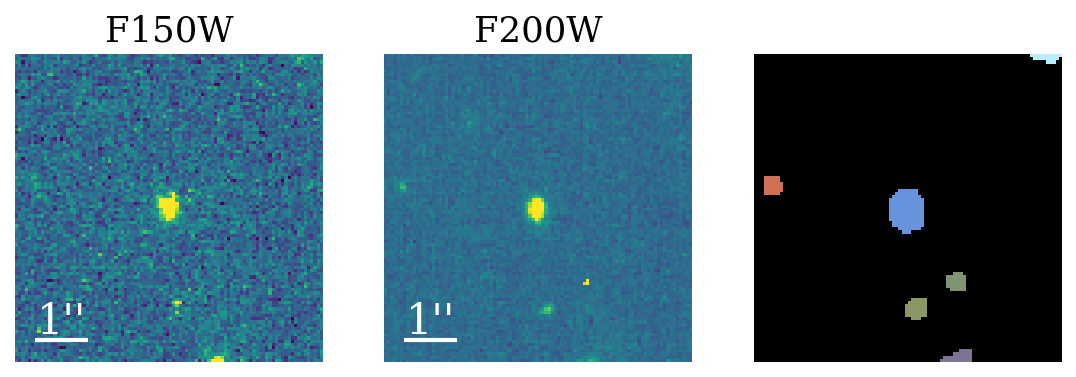

In [44]:
def scale_bar(ax, d, dist=1/0.13, text='1"', color='black', flipped=False, fontsize=15,linewidth=2):
    if flipped:
        p0 = d - d / 15. - dist
        p1 = d / 15.
        ax.plot([p0, p0 + dist], [p1, p1], linewidth=linewidth, color=color)
        ax.text(p0 + dist / 2., p1 + 0.02 * d, text, fontsize=fontsize, color=color, ha='center')
    else:
        p0 = d / 15.
        ax.plot([p0, p0 + dist], [p0, p0], linewidth=linewidth, color=color)
        ax.text(p0 + dist / 2., p0 + 0.02 * d, text, fontsize=fontsize, color=color, ha='center')
# Get indices of FITS hdu which are references images        
ref_indices =[]
ref_filters =[]
for i in range(len(beam_hdul)):
    try:
        if beam_hdul[i].header['EXTNAME']=='REF':
            #print(beam_hdul[i].header['PUPIL'])
            ref_indices.append(i)
            ref_filters.append(beam_hdul[i].header['PUPIL'])
    except:
        pass
ref_indices= np.array(ref_indices)
ref_filters = np.array(ref_filters)
ref_filters_list = np.unique(ref_filters)
print('reference bands:',ref_filters_list)

fig,axs= plt.subplots(1,len(ref_filters_list)+1,figsize=(4*len(ref_filters_list)+1,4),dpi=150)
axs=axs.ravel()
for i in range(len(ref_filters_list)):
    sel = (np.where(ref_filters==ref_filters_list[i]))[0]
    hdul_ind= ref_indices[sel[0]]
    deltaPix= beam_hdul[hdul_ind].header['PIXSCALE'] # pixel scale
    ref_im=  beam_hdul[hdul_ind].data
    
    if i==0:
        z = ZScaleInterval()
        zmin,zmax = z.get_limits(ref_im)
    axs[i].imshow(ref_im,origin='lower',vmin=zmin,vmax=zmax)
    if ref_filters_list[i]=='F200W': # show segmentation map for F200W band 
        seg_im=  beam_hdul[hdul_ind+1].data
        segmap_cmap=get_cmap(seg_im)
        axs[i+1].imshow(seg_im,origin='lower',cmap=segmap_cmap)

    axs[i].axis('off')
    axs[i].set_title('%s' % ref_filters_list[i] ,fontsize=myfontsize-5)
    scale_bar(axs[i], np.shape(ref_im)[0], dist=1/deltaPix, text=r"1''",
              fontsize=myfontsize-2,color='w')
    
axs[-1].axis('off')  

# Plot 1D spectra

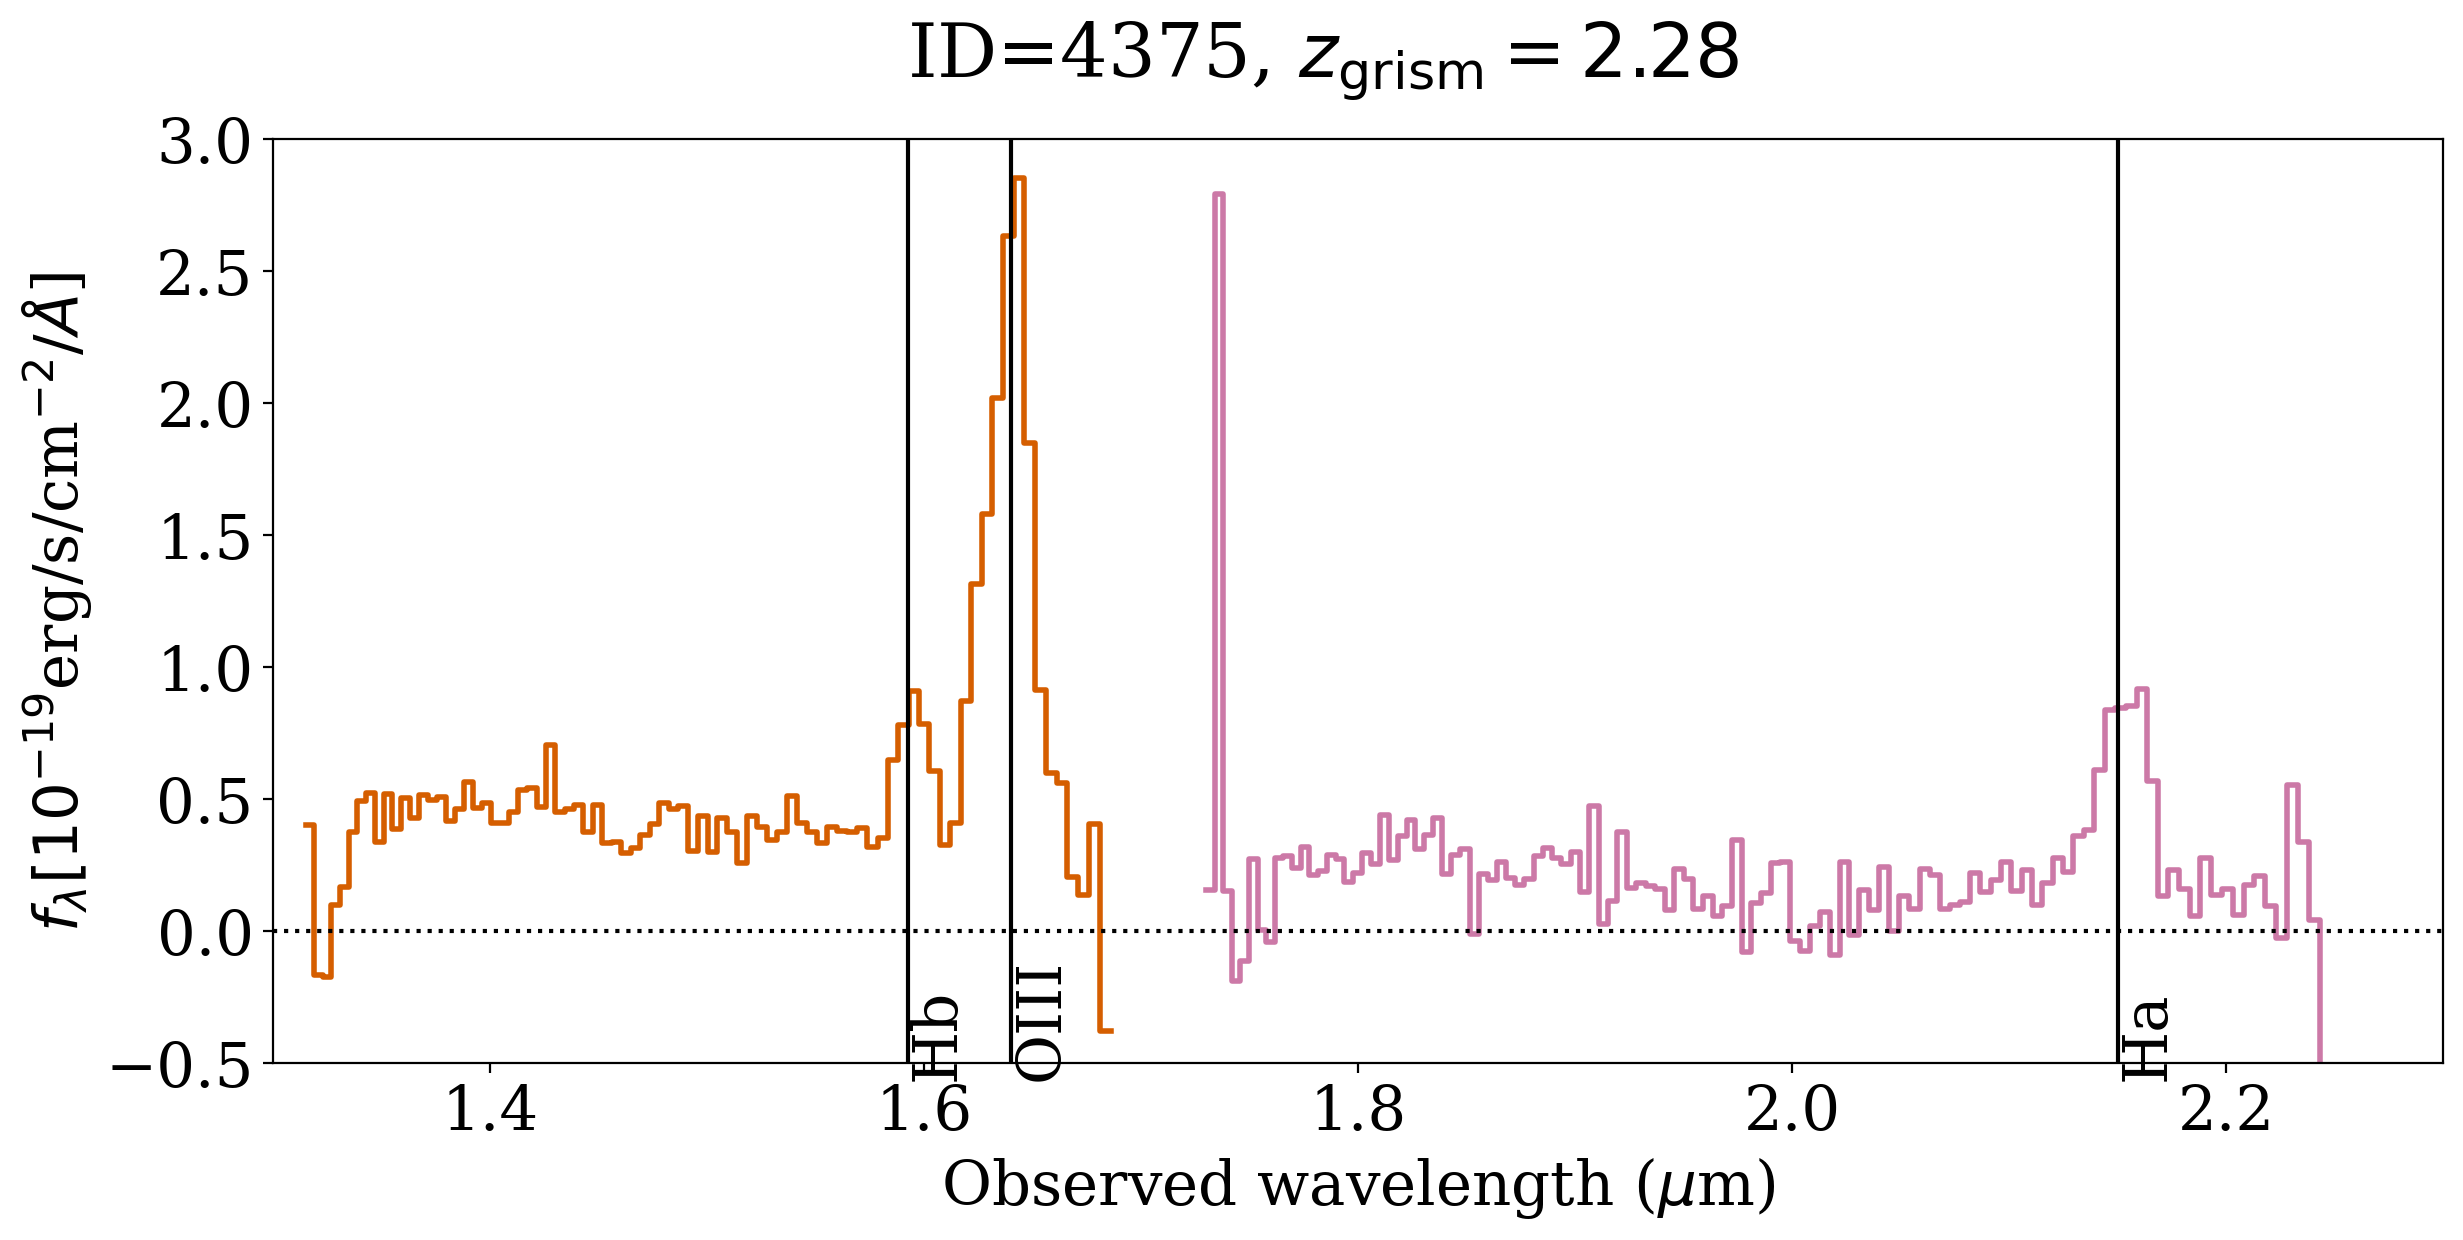

In [45]:
label_each_lines=True # add label to each emission line?
fig,ax= plt.subplots(figsize=(14,6),dpi=200)

for i in range(len(filters)):
    spec1d = Table(spec1d_hdul[filters[i]].data)
    flux =(spec1d['flux']/spec1d['flat'])/(1.e-19 ) # 1D spectra
    cont=(spec1d['cont']/spec1d['flat'])/(1.e-19 ) # continuum model
    contam= (spec1d['contam']/spec1d['flat'])/(1.e-19 ) # contamination model 
                       
    ax.step(spec1d['wave']/(1e+4),flux,
    color=grism_colors[filters[i]],where='mid',linestyle='-',label='lines',lw=2)

ax.set_xlim(1.3,2.3)
ax.set_ylim(-0.5,3)
ax.axhline(y=0,color='k',ls=':')
ax.set_xlabel(r'Observed wavelength ($\mu$m)')
ax.set_ylabel(r'$f_{\lambda}[10^{-19}$erg/s/cm$^{-2}/\AA$]')
ymin,ymax=ax.get_ylim()
fig.suptitle(r'ID=%d, $z_{\mathrm{grism}}=%.2f$' % (full_hdul[0].header['ID'],
                                                    full_hdul[0].header['REDSHIFT']),fontsize=myfontsize+5)
if (label_each_lines==True) & (len(lines_prop_dict['name'])>0):
 
    for i in range(len(lines_prop_dict['name'])):
        linename= lines_prop_dict['name'][i]
        ax.axvline(x=lines_prop_dict['wavelength_obs'][linename]/10000.0,color='k' )
        ax.text(lines_prop_dict['wavelength_obs'][linename]/10000.0,ymin-0.005*ymax,
                '%s'  % lines_prop_dict['name'][i],fontsize=myfontsize,
                       rotation=90)

# Plot Emission Line Maps

full_line_list ['Ha', 'OIII', 'Hb']


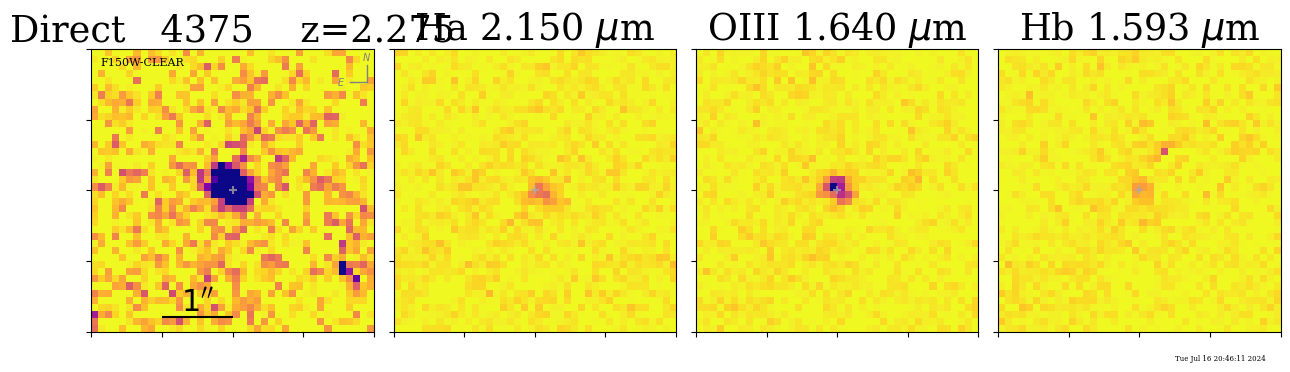

In [46]:
# Plot emission line maps for lines with SNR>5
line_size=1.6
dscale=1./4
scale_linemap=1 
#full_line_list=['OII', 'Hb', 'OIII', 'Ha+NII', 'Ha', 'SII', 'SIII']

fig = show_drizzled_lines(full_hdul, full_line_list=lines_prop_dict['name']) 
        


# Plot 2D spectra

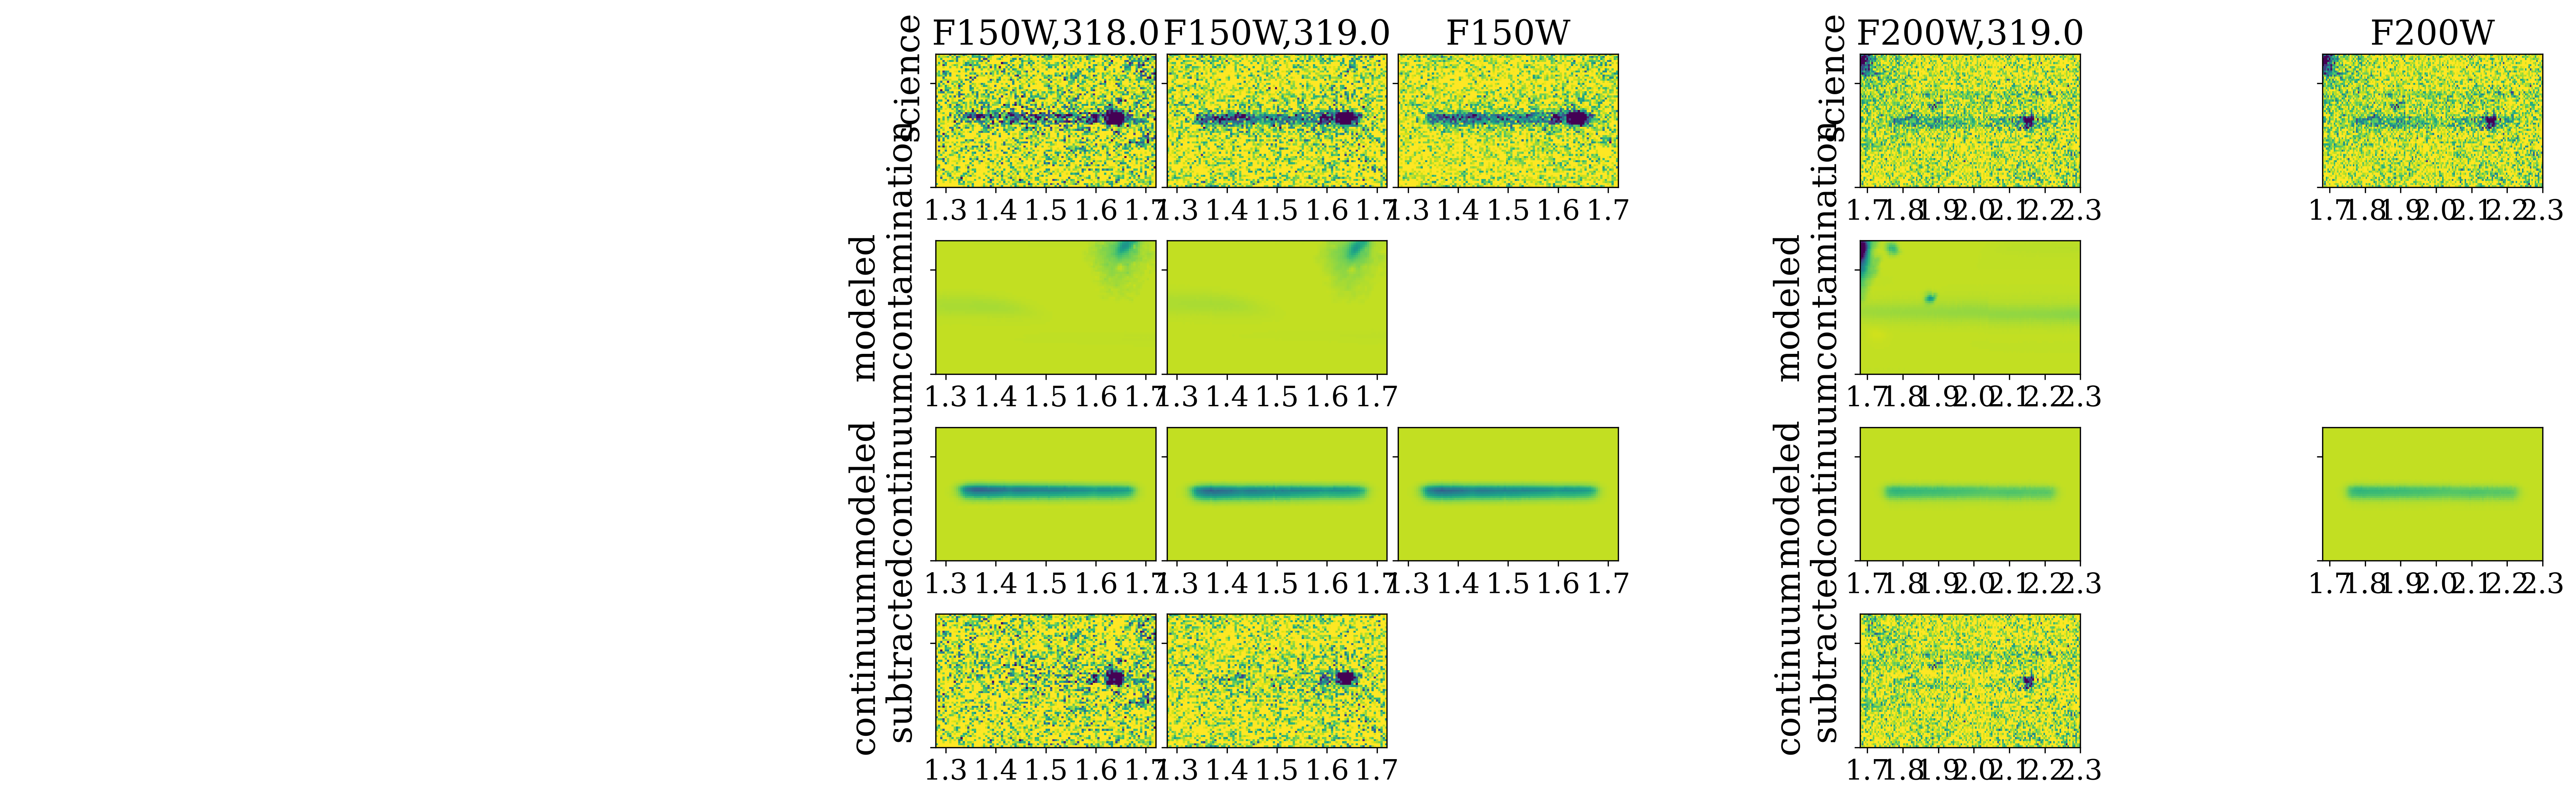

In [47]:

fig = plt.figure(constrained_layout=False,dpi=300,figsize=(25,8))
gs1 = fig.add_gridspec(nrows=4, ncols=11, left=0.05, right=0.95,
                        wspace=0.05,hspace=0.4)

row=-1
axs_sci_f115w= [fig.add_subplot(gs1[row+1, 0]),fig.add_subplot(gs1[row+1, 1]),fig.add_subplot(gs1[row+1, 2])]
axs_sci_f150w= [fig.add_subplot(gs1[row+1,4]),fig.add_subplot(gs1[row+1, 5]),fig.add_subplot(gs1[row+1, 6])]
axs_sci_f200w= [fig.add_subplot(gs1[row+1,8]),fig.add_subplot(gs1[row+1, 9]),fig.add_subplot(gs1[row+1, -1])]

axs_cont_f115w= [fig.add_subplot(gs1[row+2, 0]),fig.add_subplot(gs1[row+2, 1]),fig.add_subplot(gs1[row+2, 2])]
axs_cont_f150w= [fig.add_subplot(gs1[row+2,4]),fig.add_subplot(gs1[row+2, 5]),fig.add_subplot(gs1[row+2, 6])]
axs_cont_f200w= [fig.add_subplot(gs1[row+2,8]),fig.add_subplot(gs1[row+2, 9]),fig.add_subplot(gs1[row+2, -1])]

axs_model_f115w= [fig.add_subplot(gs1[row+3, 0]),fig.add_subplot(gs1[row+3, 1]),fig.add_subplot(gs1[row+3, 2])]
axs_model_f150w= [fig.add_subplot(gs1[row+3,4]),fig.add_subplot(gs1[row+3, 5]),fig.add_subplot(gs1[row+3, 6])]
axs_model_f200w= [fig.add_subplot(gs1[row+3,8]),fig.add_subplot(gs1[row+3, 9]),fig.add_subplot(gs1[row+3, -1])]
# # Sci image - continuum
axs_conti_subtracted_f115w= [fig.add_subplot(gs1[row+4, 0]),fig.add_subplot(gs1[row+4, 1]),fig.add_subplot(gs1[row+4, 2])]
axs_conti_subtracted_f150w= [fig.add_subplot(gs1[row+4,4]),fig.add_subplot(gs1[row+4, 5]),fig.add_subplot(gs1[row+4, 6])]
axs_conti_subtracted_f200w= [fig.add_subplot(gs1[row+4,8]),fig.add_subplot(gs1[row+4, 9]),fig.add_subplot(gs1[row+4, -1])]

# show 2D spectra (science), modeled contamination, and modeled continuum
axs_f115w_spec2d= np.array([axs_sci_f115w,axs_cont_f115w,axs_model_f115w,axs_conti_subtracted_f115w])
axs_f150w_spec2d= np.array([axs_sci_f150w,axs_cont_f150w,axs_model_f150w,axs_conti_subtracted_f150w])
axs_f200w_spec2d= np.array([axs_sci_f200w,axs_cont_f200w,axs_model_f200w,axs_conti_subtracted_f200w])

          

get_2dspectra(hdu=spec2d_hdul,axs_f115w=axs_f115w_spec2d,
              axs_f150w=axs_f150w_spec2d,axs_f200w=axs_f200w_spec2d)
if 'F115W' not in  filters:
    axs=axs_f115w_spec2d.ravel()
    for ax in axs:
        ax.axis('off')
if 'F150W' not in filters:
    axs=axs_f150w_spec2d.ravel()
    for ax in axs:
        ax.axis('off')
if 'F200W' not in filters:
    axs=axs_f200w_spec2d.ravel()
    for ax in axs:
        ax.axis('off')
for axs in [axs_f115w_spec2d,axs_f150w_spec2d,axs_f200w_spec2d]:
    axs=axs.ravel()
    for ax in axs:
        for item in ([ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize=myfontsize-4)

# Plot P(z)

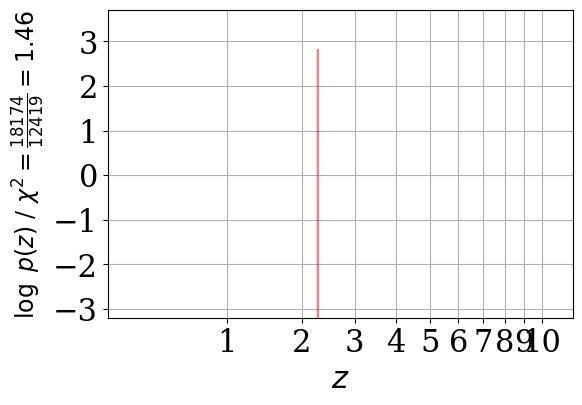

In [48]:
fig,axz= plt.subplots(figsize=(6,4),dpi=100)

zfit_stack=full_hdul['ZFIT_STACK'].data
zgrid = zfit_stack['zgrid']
pdf =zfit_stack['pdf']
zmi, zma = zgrid.min(), zgrid.max()
if (zma-zmi) > 5:
    ticks = np.arange(np.ceil(zmi), np.floor(zma), 1)
    lz = np.log(1+zgrid)
    axz.plot(lz, np.log10(pdf), color='red', alpha=0.5)
    axz.set_xticks(np.log(1+ticks))
    axz.set_xticklabels(np.cast[int](ticks))
    axz.set_xlim(lz.min(), lz.max())
else:
    axz.plot(zgrid, np.log10(pdf), color='red', alpha=0.5)
    axz.set_xlim(zmi, zma)
axz.set_xlabel(r'$z$')
axz.set_ylabel(r'$\log\ p(z)$'+' / ' + r'$\chi^2=\frac{{{0:.0f}}}{{{1:d}}}={2:.2f}$'.format(full_hdul['ZFIT_STACK'].header['CHIMIN'], 
                                                                                            full_hdul['ZFIT_STACK'].header['DOF'],
                                                                                            full_hdul['ZFIT_STACK'].header['CHIMIN']/full_hdul['ZFIT_STACK'].header['DOF']),
              fontsize=myfontsize-5)
# axz.set_yticks([1,4,9,16,25])

pzmax = np.log10(pdf.max())
axz.set_ylim(pzmax-6, pzmax+0.9)
axz.grid()
axz.yaxis.set_major_locator(MultipleLocator(base=1))

# OutThere-HUDFN catalogs
We will apply a basic selection criteria and make a histogram of grism redshifts

In [49]:

def compute_ngoodlines(lines_cat=None,snr_ew_thresh = 5,ew_thresh  = 20,
                       line_list = ['OII','Hb', 'OIII','Ha','SII','SIII']):
    """
    Function for counting the number of good emission lines (those lines with the SNR_EW and EW
    exceeding the thresholds 
    input:
    -- lines_cat: Astropy Table of emission lines
    -- snr_ew_thresh: minimum SNR of equivalent width 
    -- ew_thresh : # minimum rest-frame equivalent width 
    -- line_list: a list of emission lines to consider
    
    output:
    -- n_goodlines: number of emission lines satisfying condition for each object.
    """
    n_goodlines= np.zeros(len(lines_cat))
    for i in range(len(lines_cat)): 
        flags=[]
        flags.append( [1 for line in line_list if (lines_cat['%s_EQW_50' % line][i]/lines_cat['%s_EQW_1sigma' % line][i] > snr_ew_thresh)  & (lines_cat['%s_EQW_50' % line][i]>ew_thresh)   ])
        n_goodlines[i]=np.sum(flags)   
    return n_goodlines


cat= Table((fits.open('%s_redshift_%s.fits' % (root, catalog_ver)   ))[1].data)
lines_cat= Table((fits.open('%s_lines_%s.fits' % (root,catalog_ver)  ))[1].data)

snr_ew_thresh = 5
ew_thresh  = 20

# Counting the number of (major) emission lines that have high SNR in EW and EW > 20 Anstrom 
n_goodlines =compute_ngoodlines(lines_cat=lines_cat,snr_ew_thresh = snr_ew_thresh,ew_thresh  = ew_thresh,
                       line_list = ['OII','Hb', 'OIII','Ha','SII','SIII'])



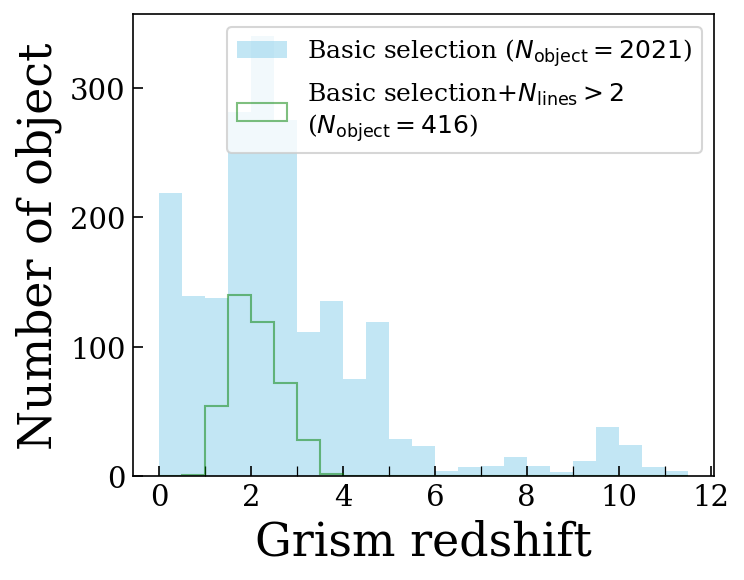

In [50]:
# Basic selection
contam_frac_thresh= 0.8 # fraction of contamination 
selection = ((cat['red_chi2']<3) 
             & (cat['contamfrac_f115w']<contam_frac_thresh) 
             & (cat['contamfrac_f150w']<contam_frac_thresh) 
             & (cat['contamfrac_f200w']<contam_frac_thresh) 
             & (cat['npeak_pz']<=2))

# Add the requirement that the object has number of good emission lines equal or more than two lines
selection_lines = selection & (n_goodlines>=2)

Nobjs = len((np.where(selection))[0])
Nobjs_lines = len((np.where(selection_lines))[0])
fig,ax= plt.subplots(figsize=(5,4),dpi=150)

zbins= np.arange(0,12,0.5)
_=ax.hist(cat['z_map'][selection], bins=zbins, color='skyblue', histtype='stepfilled',alpha=0.5,
        label=r'Basic selection ($N_{\mathrm{object}}=%d$)' % Nobjs)

_=ax.hist(cat['z_map'][selection_lines], bins=zbins, color='green', histtype='step',alpha=0.5,
        label=r'Basic selection+$N_{\mathrm{lines}}>2$'+'\n'+'($N_{\mathrm{object}}=%d$)' % Nobjs_lines)


ax.legend(loc=1,fontsize=myfontsize-10)
ax.set_xlabel('Grism redshift')
ax.set_ylabel('Number of object')
ax.tick_params(which='both',axis='both', direction='in',length=5)
ax.tick_params(axis='both', labelsize=myfontsize-8)

#ax.yaxis.set_major_locator(MultipleLocator(200))
#ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

# Read OutThere-HUDFN cross-matched with CANDELS redshift catalog.
We will read the catalog and compare the OutThere grism redshifts and the CANDELS redshifts

In [51]:



matched_candels_cat= Table((fits.open('%s_CANDELS_crossmatched_%s.fits' % (root,catalog_ver)  ))[1].data)
z_candels='z_best_CANDELS'
dz_1pz = (cat['z_map']-matched_candels_cat[z_candels])/(1+matched_candels_cat[z_candels])


selection_candels  = selection & (matched_candels_cat[z_candels]>0)
# Add the requirement that the object has number of good emission lines equal or more than two lines
selection_lines_candels = selection_candels & (n_goodlines>=2)

# Compute statistics for the comparison between grism redshifts and CANDELS
def statistics_compare_redshifts(selection_candels=None,z_candels='z_best_CANDELS'):
    dz_1pz = (cat['z_map']-matched_candels_cat[z_candels])/(1+matched_candels_cat[z_candels])
    sigma_nmad = 1.48* stats.median_abs_deviation(np.abs(dz_1pz[selection_candels]), scale='normal')
    outliers= (np.where(np.abs(dz_1pz[selection_candels]) >  0.15))[0]
    Noutliers = len(outliers)
    Ntot = len(dz_1pz[selection_candels])
    frac_outliers = 100*(Noutliers/Ntot)
    print('Total number of matched sources:', Ntot)
    print('Total number of outliers:',Noutliers,'(%.2f%%)' % frac_outliers)
    print('Sigma_nmad:',sigma_nmad)

    return sigma_nmad,frac_outliers
print('Apply basic selection')
sigma_nmad,frac_outliers = statistics_compare_redshifts(selection_candels=selection_candels,
                                                        z_candels=z_candels)

print('Apply basic selection and requires at least two major emission lines with SNR_EW > %d and EW> %d Angstrom' % (snr_ew_thresh,ew_thresh))
sigma_nmad_wlines,frac_outliers_wlines = statistics_compare_redshifts(selection_candels=selection_lines_candels,
                                                        z_candels=z_candels)


Apply basic selection
Total number of matched sources: 1389
Total number of outliers: 814 (58.60%)
Sigma_nmad: 0.558060583096013
Apply basic selection and requires at least two major emission lines with SNR_EW > 5 and EW> 20 Angstrom
Total number of matched sources: 333
Total number of outliers: 83 (24.92%)
Sigma_nmad: 0.045598862323089816


Text(0.5, 0.98, 'Basic selection with $N_{\\mathrm{lines}}>2$')

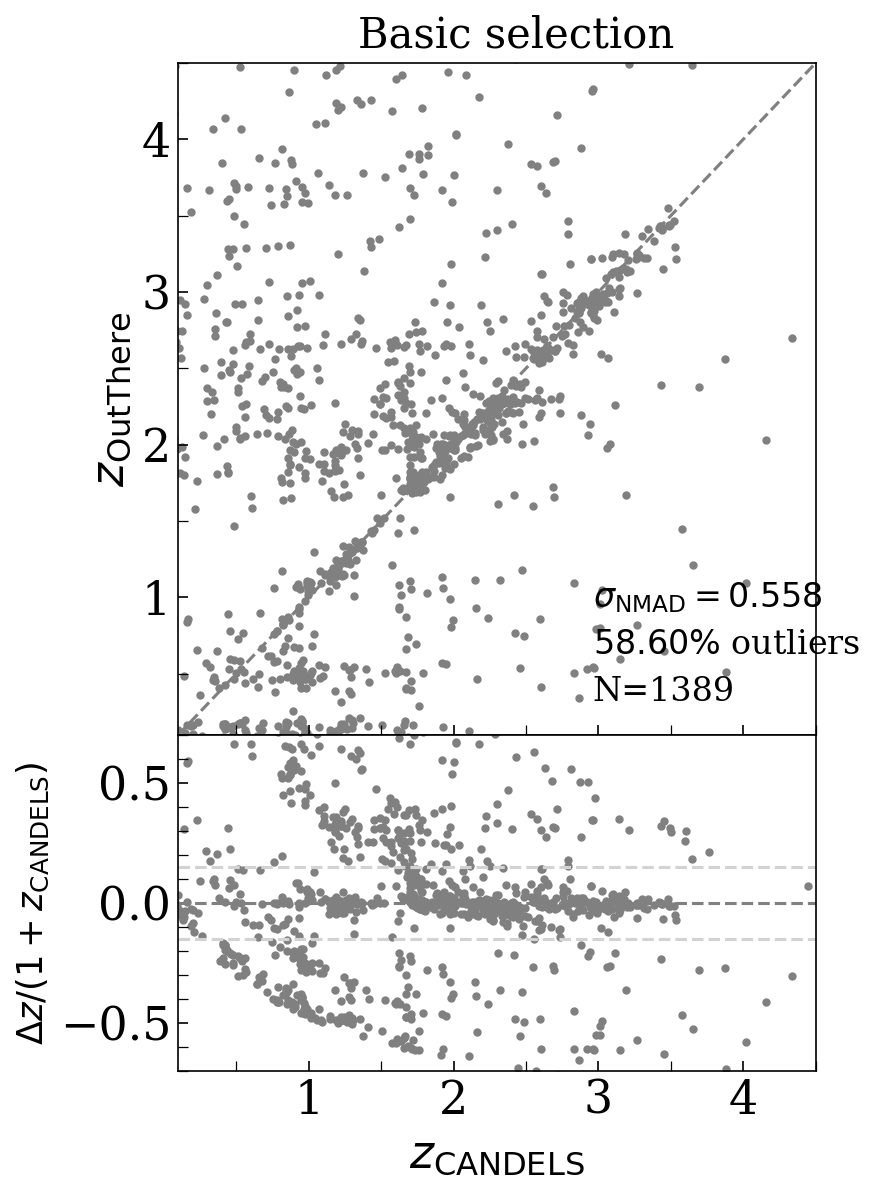

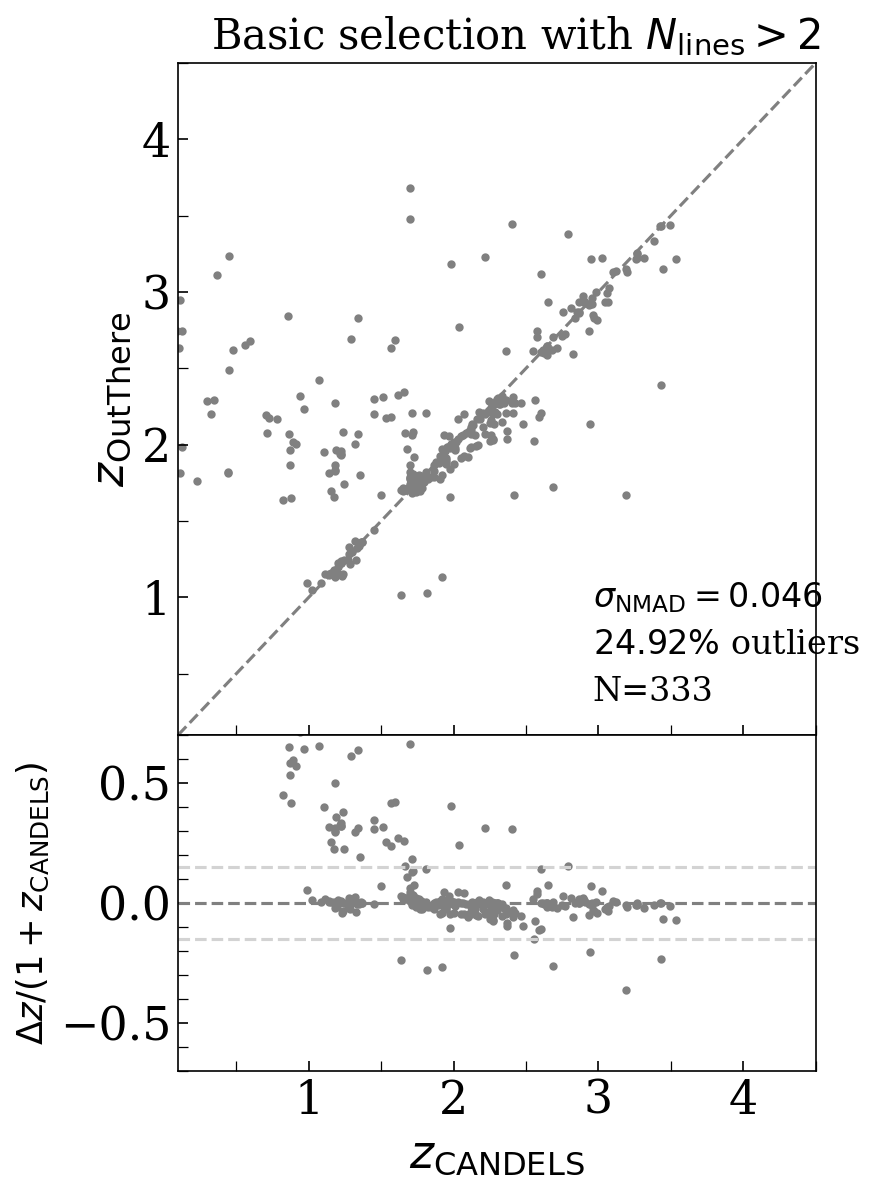

In [52]:
def create_zzplot(zmin=0.1,zmax=4.5):
    """
    # Initiate a plot for comparing redshifts.
    zmin,zmax: y-axis range
    """
    fig = plt.figure(constrained_layout=False,dpi=150,figsize=(5,8))
    width=0.43
    left=0.05
    right=0.9
    top=0.94
    bottom=0.1
    gs1 = fig.add_gridspec(nrows=3, ncols=1, left=left, right=right,top=top,bottom=bottom,
                            wspace=0.0,hspace=0)
    f_ax1 = fig.add_subplot(gs1[:-1, :])
    f_ax2 = fig.add_subplot(gs1[-1, :])
    axs=[f_ax1,f_ax2]

    axs[0].set_ylim(zmin,zmax)
    axs[0].plot([zmin,zmax],[zmin,zmax],color='grey',ls='--')
    axs[1].plot([zmin,zmax],[0,0],color='grey',ls='--')  
    axs[1].plot([zmin,zmax],[-0.15,-0.15],color='lightgrey',ls='--') 
    axs[1].plot([zmin,zmax],[0.15,0.15],color='lightgrey',ls='--') 

    axs[0].set_ylabel(r'$z_{\mathrm{OutThere}}$')
    axs[1].set_ylabel(r'$\Delta z/(1+z_{\mathrm{CANDELS}})$',fontsize=myfontsize-5)

    #    axs[1].set_ylabel(r'$\Delta z/(1+z_{\mathrm{spec}})$',fontsize=myfontsize-5)
    #axs[0].legend(fontsize=myfontsize,loc=1)
    axs[0].set_xticklabels([])
    axs[1].set_xlabel(r'$z_{\mathrm{CANDELS}}$')

    axs[1].set_ylim(-0.7,0.7)
    for i in range(len(axs)):
        axs[i].set_xlim(zmin,zmax)

        axs[i].xaxis.set_major_locator(MultipleLocator(1))
        axs[i].xaxis.set_minor_locator(MultipleLocator(0.5))
        axs[i].tick_params(which='both',axis='both', direction='in',length=5)
        if (i==0):
            axs[i].yaxis.set_major_locator(MultipleLocator(1))
            axs[i].yaxis.set_minor_locator(MultipleLocator(0.5))
        if (i==1):
            axs[i].yaxis.set_major_locator(MultipleLocator(0.5))
            axs[i].yaxis.set_minor_locator(MultipleLocator(0.1))
    return fig,axs
fig,axs=create_zzplot(zmin=0.1,zmax=4.5)

# plot for all OutThere sources matched with CANDELS catalog (with basic selection)
axs[0].scatter(matched_candels_cat[z_candels][selection_candels], cat['z_map'][selection_candels],
               marker='.',color='grey')
axs[1].scatter(matched_candels_cat[z_candels][selection_candels],dz_1pz[selection_candels],
               marker='.',color='grey')
axs[0].text(0.65,0.19,r'$\sigma_{\mathrm{NMAD}}=%.3f$' % sigma_nmad ,
                fontsize=myfontsize-6,transform=axs[0].transAxes)
axs[0].text(0.65,0.12,r'$%.2f\%%$ outliers' % frac_outliers ,
            fontsize=myfontsize-6,transform=axs[0].transAxes)
axs[0].text(0.65,0.05,r'N=%d' % len(matched_candels_cat[z_candels][selection_candels]) ,
            fontsize=myfontsize-6,transform=axs[0].transAxes)
fig.suptitle('Basic selection',fontsize=myfontsize-2)


# plot for all OutThere sources matched with CANDELS catalog (with basic selection) and 
# requires at least two major emission lines with high SNRs


fig,axs=create_zzplot(zmin=0.1,zmax=4.5)

# plot for all OutThere sources matched with CANDELS catalog (with basic selection)
axs[0].scatter(matched_candels_cat[z_candels][selection_lines_candels], cat['z_map'][selection_lines_candels],
               marker='.',color='grey')
axs[1].scatter(matched_candels_cat[z_candels][selection_lines_candels],dz_1pz[selection_lines_candels],
               marker='.',color='grey')
axs[0].text(0.65,0.19,r'$\sigma_{\mathrm{NMAD}}=%.3f$' % sigma_nmad_wlines,
                fontsize=myfontsize-6,transform=axs[0].transAxes)
axs[0].text(0.65,0.12,r'$%.2f\%%$ outliers' % frac_outliers_wlines ,
            fontsize=myfontsize-6,transform=axs[0].transAxes)
axs[0].text(0.65,0.05,r'N=%d' % len(matched_candels_cat[z_candels][selection_lines_candels]) ,
            fontsize=myfontsize-6,transform=axs[0].transAxes)
fig.suptitle(r'Basic selection with $N_{\mathrm{lines}}>2$',fontsize=myfontsize-2)
